In [52]:
# HIDDEN
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plots.style.use('fivethirtyeight')

In [53]:
# HIDDEN

def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

### Comparing Two Samples ###
The nearest neighbor approach to classification is motivated by the idea that an individual is likely to resemble its nearest neighbors. Looking at this another way, we can say that individuals in one class don't resemble individuals in another. Machine learning gives us a powerful way to spot this lack of resemblance and use it to classify. It illuminates patterns that we wouldn't necessarily be able to spot just by examining one or two attributes at at time.

However, there is much that we can learn from just a single attribute. To see this, we will compare the distributions of the attribute in the two classes.

Let's take a look at Brittany Wenger's breast cancer data and see whether using just one attribute has any hope of producing a reasonable classifier. As before, we'll do our exploration on a randomly chosen training set, and test our classifer on the remaining hold-out set.

In [54]:
patients = Table.read_table('breast-cancer.csv').drop('ID')

In [55]:
shuffled_patients = patients.sample(with_replacement=False) 
training_set = shuffled_patients.take(np.arange(341))
test_set  = shuffled_patients.take(np.arange(341, 683))

In [56]:
training_set

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,2,1,1,0
5,1,1,1,1,1,1,1,1,0
4,1,1,1,2,1,1,1,1,0
5,1,2,1,2,1,3,1,1,0
4,10,8,5,4,1,10,1,1,1
7,2,4,1,3,4,3,3,1,1
9,4,5,10,6,10,4,8,1,1
3,1,1,1,2,2,3,1,1,0
3,2,1,1,2,1,2,2,1,0
6,3,3,5,3,10,3,5,3,0


Let's see what the second attribute, `Uniformity of Cell Size`, can tell us about a patient's class.

In [57]:
training_cellsize = training_set.select('Class', 'Uniformity of Cell Size').relabel(1, 'Uniformity')
training_cellsize

Class,Uniformity
0,1
0,1
0,1
0,1
1,10
1,2
1,4
0,1
0,2
0,3


The `Class` and `Uniformity` columns appear numerical but they're really both categorical. The classes are "cancerous" (1) and "not cancerous" (0). Uniformity was rated on a scale of 1 to 10, but those labels were determined by humans, and they could just as well have been ten labels like "pretty uniform", "not uniform at all", and so on.  (A 2 isn't necessarily twice as uniform as a 1.)  So we are comparing two categorical distributions, one for each class.

For each class, we need the number of training set patients who had each uniformity rating. The `pivot` method will do the counting for us.

In [58]:
training_counts = training_cellsize.pivot('Class', 'Uniformity')

In [59]:
training_counts

Uniformity,0,1
1,181,3
2,21,2
3,16,15
4,4,18
5,0,17
6,0,8
7,0,8
8,1,13
9,1,4
10,0,29


We now have something resembling a distribution of uniformity rating, for each class. And the two look rather different. However, let's be careful – while the total number of patients in the two classes is 341 (the size of the training set), more than half are in Class 0.

In [60]:
np.sum(training_counts.column('0'))

224

So to compare the two distributions we should convert the counts to proportions and then visualize.

In [61]:
def proportions(array):
    return array/np.sum(array)

In [62]:
training_dists = training_counts.select(0).with_columns(
   '0', proportions(training_counts.column('0')),
    '1', proportions(training_counts.column('1'))
)

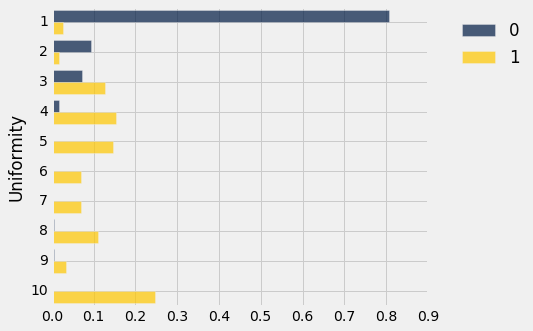

In [63]:
training_dists.barh('Uniformity')

Those two distributions don't look the same at all! In fact they look so different that we should be able to construct a perfectly decent classifier based on a very straightforward observation about the difference. A simple classification rule would be, "If the uniformity is bigger than 3, say the Class is 1; that is, the cell is cancerous. Otherwise say the Class is 0." 

Can something so crude be any good? Let's try it out. For any individual in the test set, all we have to do is see whether or not the uniformity rating is bigger than 3. For example, for the first 4 patients we'll get an array of four booleans:

In [64]:
test_set.take(np.arange(4)).column('Uniformity of Cell Size') > 3

array([ True, False, False, False], dtype=bool)

Remember that `True` equals 1, which is the Class we're going to assign if the uniformity is bigger than 3. So to measure the accuracy of our crude classifier, all we have to do is find the proportion of test set patients for which the classification is the same as the patient's known class. We'll use the `count_equal` function we wrote in the previous section.

In [65]:
classification = test_set.column('Uniformity of Cell Size') > 3

count_equal(classification, test_set.column('Class'))/test_set.num_rows

0.935672514619883

That's pretty accurate, even though we're only using a one-attribute one-line-of-code classifier!

Does that mean that the nearest neighbor methods of the previous chapter are unnecessary? No, because those are even more accurate, and for cancer diagnoses any patient would want as accurate a method as possible. But it's reassuring to see that simple methods aren't bad.